### Circuit Size Tipping Point

#### Why:
the number of students/districts that can upgrade by getting a certain bandwidth would be very impactful! However, overall bandwidth needed is more compelling than increase. The ideal message is if we said "every rural district should get a gbps" .. etc

#### What:
- Add more intervals after 500% since there are so many
- Create a version with percentages 

Using `projected_bw_fy2018` uses the concurrency factor for Medium/Larges/Megas in calculating projected bw needed to meet 1 Mbps

In [1]:
from __future__ import division
from collections import defaultdict
import numpy as np
import os
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [2]:
HOST_DAR = os.environ.get("HOST_DAR")
USER_DAR = os.environ.get("USER_DAR")
PASSWORD_DAR = os.environ.get("PASSWORD_DAR")
DB_DAR = os.environ.get("DB_DAR")
PORT_DAR = os.environ.get("PORT_DAR")
GITHUB = os.environ.get("GITHUB")

#open connection to DB
myConnection = psycopg2.connect( host=HOST_DAR, 
                                user=USER_DAR, 
                                password=PASSWORD_DAR, 
                                database=DB_DAR, 
                                port=PORT_DAR)

cur = myConnection.cursor()
cur.execute(open('circuit_size_tipping_point_query.sql').read())
names = [x[0] for x in cur.description]
rows = cur.fetchall()
df = pd.DataFrame(rows, columns=names)

In [3]:
df.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,projected_bw_fy2018,projected_bw_fy2018_cck12,meeting_2018_goal_oversub
0,881421,2019,Traditional,True,True,5687,2000,3980.9,5000,False
1,881422,2019,Traditional,True,True,194,1000,194,200,True
2,881423,2019,Traditional,True,True,1319,2000,1319,2000,True
3,881424,2019,Traditional,True,True,5387,1000,3770.9,5000,False
4,881427,2019,Traditional,True,True,13938,10000,9756.6,10000,True


### Masks/Filters

In [4]:
mask_not_meeting = df.meeting_2018_goal_oversub == False
mask_meeting = df.meeting_2018_goal_oversub == True
mask_traditional = df.district_type == 'Traditional'
mask_fit_ia = df.fit_for_ia == True
mask_in_universe = df.in_universe == True

### Convert Decimal to Float

In [5]:
numeric_cols = ['num_students', 'ia_bw_mbps_total','projected_bw_fy2018',]
df[numeric_cols] = df[numeric_cols].astype(float)

### Extrapolation

In [6]:
num_population_districts = df[mask_in_universe & mask_traditional].district_id.nunique()
num_sample_districts = df[mask_fit_ia &
                          mask_in_universe &
                          mask_traditional].district_id.nunique()

print(f"Number of population districts: {num_population_districts}")
print(f"Number of sample districts: {num_sample_districts}")

Number of population districts: 12912
Number of sample districts: 12647


In [7]:
# districts not meeting 1 mbps
df_fit_ia = df[mask_not_meeting & 
                mask_traditional & 
                mask_fit_ia & 
                mask_in_universe]

In [8]:
df_fit_ia.shape

(7805, 10)

### Calculating Bandwidth Percent Change

In [10]:
# add 'bw_pct_change'
df_fit_ia.loc[:, 'bw_pct_change_to_meet_2018_goal'] = ((df_fit_ia['projected_bw_fy2018'] - df_fit_ia['ia_bw_mbps_total'])/df_fit_ia['ia_bw_mbps_total'])*100


In [11]:
df_fit_ia.head()

,district_id,funding_year,district_type,in_universe,fit_for_ia,num_students,ia_bw_mbps_total,projected_bw_fy2018,projected_bw_fy2018_cck12,meeting_2018_goal_oversub,bw_pct_change_to_meet_2018_goal
0,881421,2019,Traditional,True,True,5687.0,2000.0,3980.9,5000,False,99.045000
3,881424,2019,Traditional,True,True,5387.0,1000.0,3770.9,5000,False,277.090000
5,881428,2019,Traditional,True,True,2297.0,1000.0,2297.0,3000,False,129.700000
7,881433,2019,Traditional,True,True,3858.0,1650.0,2700.6,3000,False,63.672727
9,881439,2019,Traditional,True,True,1404.0,1000.0,1404.0,2000,False,40.400000


In [12]:
locale_colors = {'Rural': '#fac4a5', 'Town':'#f26c23', 'Suburban':'#c44f27', 'Urban':'#83351a'}

### Number of Districts, Percent Bandwidth Increase, Overall: Slide 37

In [14]:
# indicate bins for categories
max_bin = 1050
increment = 50
bins = np.arange(0, max_bin, increment)

# create labels
labels = []
for i, b in enumerate(bins):
    if i == 0:
        labels.append("less than " + str(bins[i+1]) + '%')
    elif i < len(bins)-1:
        labels.append(str(bins[i])+'%')
    else:
        break

# add final category to labels
labels.append(str(max_bin-increment) +'% or over')

# categorize bw_pct_change
df_fit_ia.loc[:,'bw_pct_change_category'] = pd.cut(df_fit_ia['bw_pct_change_to_meet_2018_goal'], 
                                                     bins=bins, 
                                                     labels=labels[:-1], right=False)

# add new category
df_fit_ia.loc[:, 'bw_pct_change_category'] = df_fit_ia['bw_pct_change_category'].cat.add_categories(str(max_bin-increment) + '% or over')

# fill in Nans (anything over max_bin)
df_fit_ia[['bw_pct_change_category']] = df_fit_ia[['bw_pct_change_category']].fillna(value=str(max_bin-increment) +'% or over')


# change index to string, and count values for plotting
df_fit_ia.loc[:, 'bw_pct_change_category'] = df_fit_ia['bw_pct_change_category'].astype(str)

In [15]:
# converting list to df for merging
df_temp = pd.DataFrame({'labels': labels})
df_temp.set_index('labels', inplace=True)

# count instances of category for district count
df_pct_change = df_fit_ia.bw_pct_change_category.value_counts().to_frame()

# merge into resultant dataframe to keep order of index
df_pct_change = df_temp.merge(df_pct_change, left_index=True, right_index=True )
df_pct_change.reset_index(inplace=True)

# rename index column
df_pct_change.columns = ['pct_category', 'district_count']

# add extrapolated numbers
df_pct_change['district_count_extrapolated'] = (df_pct_change['district_count']*num_population_districts)/(num_sample_districts)

# add percentage column
df_pct_change['pct_by_category'] = df_pct_change['district_count_extrapolated']/df_pct_change['district_count_extrapolated'].sum()

In [16]:
df_pct_change

,pct_category,district_count,district_count_extrapolated,pct_by_category
0,less than 50%,1947,1987.796632,0.249455
1,50%,1487,1518.157982,0.190519
2,100%,1184,1208.809046,0.151698
3,150%,859,876.999130,0.110058
4,200%,608,620.739780,0.077899
5,250%,410,418.590970,0.052530
6,300%,320,326.705147,0.040999
7,350%,232,236.861232,0.029725
8,400%,159,162.331620,0.020372
9,450%,148,151.101131,0.018962


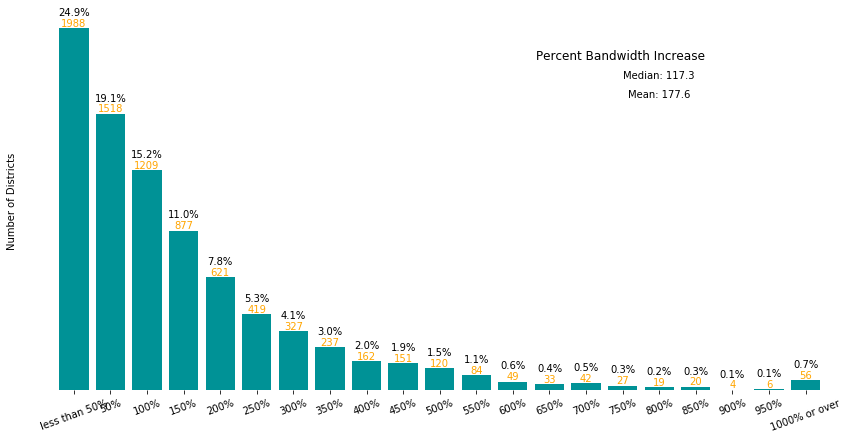

In [17]:
# plotting the figure
plt.figure(figsize=(15, 7))
xmarks = np.arange(0, df_pct_change.shape[0])
plt.bar(xmarks, df_pct_change['district_count_extrapolated'], color='#009296')

# ticks, titles, axis labels
plt.ylabel("Number of Districts")
plt.xticks(xmarks, df_pct_change.pct_category.values, rotation=20)
plt.box(on=None)
plt.yticks([])

# add sum labels
for x0, v0, label, pct_label in zip(xmarks, 
                         df_pct_change['district_count_extrapolated'], 
                         df_pct_change['district_count_extrapolated'],
                         df_pct_change['pct_by_category']
                        ):
    plt.text(x0, v0, round(label), ha='center', va='bottom', color='orange')
    plt.text(x0, v0+60, str(round(pct_label*100, 1))+'%', ha='center', va='bottom')
    
plt.text(15, 1800, "Percent Bandwidth Increase ", ha='center', va='bottom', fontsize=12)
plt.text(16, 1700, "Median: "+str(round(df_fit_ia.bw_pct_change_to_meet_2018_goal.median(), 1)), ha='center', va='bottom')
plt.text(16, 1600, "Mean: "+str(round(df_fit_ia.bw_pct_change_to_meet_2018_goal.mean(), 1)), ha='center', va='bottom');

# save
#plt.savefig("pct_bw_increase_all_v2.png", bbox_inches = 'tight')

In [1]:
# convert jupyter notebook to .py
!jupyter nbconvert --to script circuit_size_tipping_point_whiteboard_fup_072319.ipynb

[NbConvertApp] Converting notebook circuit_size_tipping_point_whiteboard_fup_072319.ipynb to script
[NbConvertApp] Writing 6345 bytes to circuit_size_tipping_point_whiteboard_fup_072319.py
